# Stochastic something

This is a script that uses the yfinance library to download historical data for a stock specified by the user's input for the stock's ticker symbol. It then calculates the Stochastic %K and %D lines for the last year of data, trains a HistGradientBoostingRegressor model on this data, and uses the model to make predictions for the next 30 days. The predictions are then plotted along with the historical data, with the addition of random noise to the predictions. The script also uses matplotlib and pandas libraries to perform data manipulation and visualization.

Enter the stock ticker symbol or 'exit' to finish: GOOG


[*********************100%%**********************]  1 of 1 completed


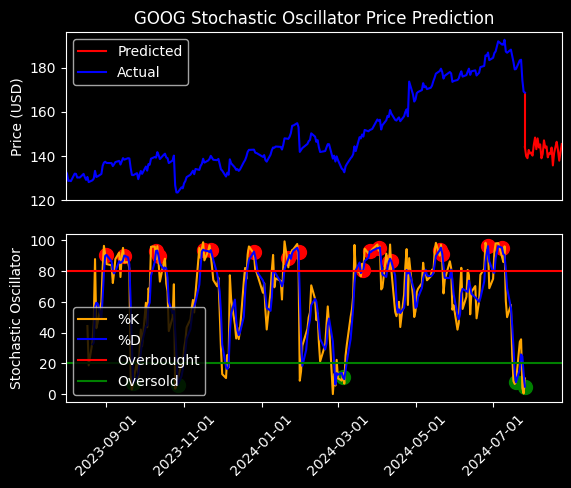

Enter the stock ticker symbol or 'exit' to finish: AAPL


[*********************100%%**********************]  1 of 1 completed


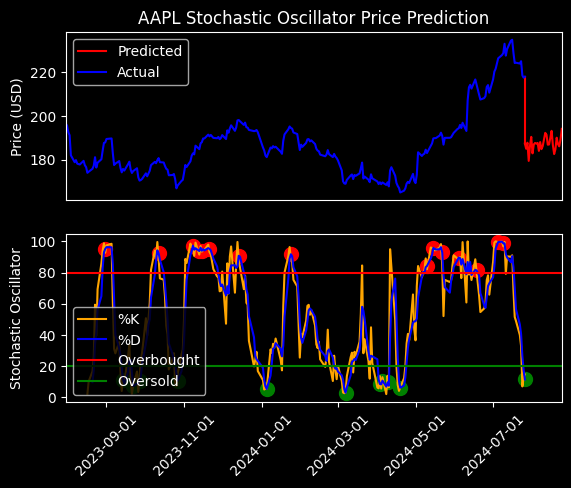

Enter the stock ticker symbol or 'exit' to finish: exit


In [1]:
import os
import warnings
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.dates as mdates
from sklearn.ensemble import HistGradientBoostingRegressor

# Suppress specific warnings
warnings.filterwarnings('ignore', category=FutureWarning, message="Series.__getitem__ treating keys as positions is deprecated.*")

while True:
    # Ask the user for the stock ticker symbol
    stock_ticker = input("Enter the stock ticker symbol or 'exit' to finish: ")
    if stock_ticker.lower() == 'exit':
        break

    # Get today's date
    today = datetime.datetime.now().date()

    # Subtract 365 days from today's date
    one_year_ago = today - datetime.timedelta(days=365)

    # Use the date one year ago as the start parameter in yf.download()
    data = yf.download(stock_ticker, start=one_year_ago)

    if data.empty:
        print("No data available for the stock ticker symbol:", stock_ticker, ". Please try another symbol.")
        continue
    else:
        # Convert the date column to a datetime object
        data['Date'] = pd.to_datetime(data.index)

        # Set the date column as the index
        data.set_index('Date', inplace=True)

        # Sort the data by date
        data.sort_index(inplace=True)

        # Get the data for the last year
        last_year = data.iloc[-365:].copy()

        # Calculate the Stochastic %K and %D lines
        last_year['%K'] = 100 * (last_year['Close'] - last_year['Low'].rolling(14).min()) / (last_year['High'].rolling(14).max() - last_year['Low'].rolling(14).min())
        last_year['%D'] = last_year['%K'].rolling(3).mean()

        # Split the data into X (features) and y (target)
        X = last_year[['%K', '%D']]
        y = last_year['Close']

        # Create an HistGradientBoostingRegressor instance
        model = HistGradientBoostingRegressor()

        # Fit the model with the data
        model.fit(X, y)

        # Make predictions for the next 30 days
        future_dates = pd.date_range(start=data.index[-1], periods=30, freq='D')
        future_data = pd.DataFrame(index=future_dates, columns=['%K','%D'])
        future_data['%K'] = last_year['%K'].iloc[-1]
        future_data['%D'] = last_year['%D'].iloc[-1]

        predictions = model.predict(future_data)
        predictions_df = pd.DataFrame(predictions, index=future_dates, columns=['Close'])

        # Calculate the standard deviation of the last year's close prices
        std_dev = last_year['Close'].std()

        # Generate random values with a standard deviation of 0.5 * the last year's close prices standard deviation
        random_values = np.random.normal(0, 0.2 * std_dev, predictions.shape)

        # Add the random values to the predicted prices
        predictions += random_values
        predictions_df = pd.DataFrame(predictions, index=future_dates, columns=['Close'])

        # Concatenate the last_year and predictions dataframes
        predictions_df = pd.concat([last_year, predictions_df])

        # Recalculate Stochastic %K and %D lines for the next 30 days
        predictions_df['%K'] = 100 * (predictions_df['Close'] - predictions_df['Low'].rolling(14).min()) / (predictions_df['High'].rolling(14).max() - predictions_df['Low'].rolling(14).min())
        predictions_df['%D'] = predictions_df['%K'].rolling(3).mean()

        # Set the style to dark theme
        style.use('dark_background')

        # Create a figure and axis
        fig, axs = plt.subplots(2,1)

        # Plot the historical data and predictions in the first subplot
        axs[0].plot(predictions_df.index[-30:], predictions_df['Close'][-30:], color='green' if predictions_df['Close'][-1] >= last_year['Close'][-1] else 'red', label='Predicted')

        axs[0].plot((predictions_df.index[-31], predictions_df.index[-30]), (predictions_df['Close'][-31], predictions_df['Close'][-30]),
        color='green' if predictions_df['Close'][-1] >= last_year['Close'][-1] else 'red')

        axs[0].plot(last_year.index, last_year['Close'], label='Actual', color='blue')

        axs[0].set_title(stock_ticker.upper() + " Stochastic Oscillator Price Prediction")
        axs[0].set_xticks([])
        axs[0].legend()

        # Plot the Stochastic %K and %D lines in the second subplot
        axs[1].plot(predictions_df.index, predictions_df['%K'], 'orange', label='%K')
        axs[1].plot(predictions_df.index, predictions_df['%D'], 'blue', label='%D')
        axs[1].set_title('')
        axs[1].legend()

        # Add overbought and oversold lines
        overbought = 80
        oversold = 20
        axs[1].axhline(y=overbought, color='red', label='Overbought')
        axs[1].axhline(y=oversold, color='green', label='Oversold')
        axs[1].legend(loc='lower left')

        # Add buy and sell signals
        for i in range(1, len(predictions_df)):
            if (predictions_df['%K'][i-1] < predictions_df['%D'][i-1]) & (predictions_df['%K'][i] > predictions_df['%D'][i]) & (predictions_df['%K'][i] < 20):
                axs[1].scatter(x=predictions_df.index[i], y=predictions_df['%D'][i], color='g', marker='o', s=100, label='Buy')
            elif (predictions_df['%K'][i-1] > predictions_df['%D'][i-1]) & (predictions_df['%K'][i] < predictions_df['%D'][i]) & (predictions_df['%K'][i] > 80):
                axs[1].scatter(x=predictions_df.index[i], y=predictions_df['%D'][i], color='r', marker='o', s=100, label='Sell')

        # Set the x-axis to show dates
        for ax in axs:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.xticks(rotation=45)

        # Set the x-axis limits to be the same for both subplots
        axs[0].set_xlim(predictions_df.index[0], predictions_df.index[-1])
        axs[1].set_xlim(predictions_df.index[0], predictions_df.index[-1])

        #Set the y-axis to show labels
        axs[0].set_ylabel('Price (USD)')
        axs[1].set_ylabel('Stochastic Oscillator')

        # Show the plot
        plt.show()
